## Statistics 101

### BIRAFFE2 dataset

In today's class, we will recall the basics of statistics.
To make it more fun and related to the our affective research, we will start by loading the BIRAFFE2 dataset collected using, among others, BITalino (i.e., the older brother of the PLUX's family of devices we use in class).

We will use the **BIRAFFE2-procedure** subset with a logs of stimuli presentation and user responses and **BIRAFFE2-metadata.csv** file.

For more details, see the [full record at Zenodo](https://doi.org/10.5281/zenodo.3865859).

In [ ]:
# necessary imports
import io
import glob
import numpy as np
import pandas as pd

# for stats
from scipy import stats
import statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import matplotlib library
import matplotlib.pyplot as plt
# if you work locally (not at Google Colab) you can activate interactive plots by changing "inline" to "notebook"
%matplotlib inline

# import bokeh
import bokeh.io, bokeh.plotting
bokeh.io.output_notebook()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Download the dataset (to Virtual Machine local filesystem)
!wget https://zenodo.org/record/3865860/files/BIRAFFE2-metadata.csv?download=1
!wget https://zenodo.org/record/3865860/files/BIRAFFE2-procedure.zip?download=1

!mv "BIRAFFE2-metadata.csv?download=1" "BIRAFFE2-metadata.csv"
!mv "BIRAFFE2-procedure.zip?download=1" "BIRAFFE2-procedure.zip"

--2022-03-28 19:58:45--  https://zenodo.org/record/3865860/files/BIRAFFE2-metadata.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27324 (27K) [text/plain]
Saving to: ‘BIRAFFE2-metadata.csv?download=1’

BIRAFFE2-metadata.c 100%[===================>]  26.68K  --.-KB/s    in 0s      

2022-03-28 19:58:47 (211 MB/s) - ‘BIRAFFE2-metadata.csv?download=1’ saved [27324/27324]

--2022-03-28 19:58:47--  https://zenodo.org/record/3865860/files/BIRAFFE2-procedure.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35900571 (34M) [application/octet-stream]
Saving to: ‘BIRAFFE2-procedure.zip?download=1’

BIRAFFE2-procedure. 100%[===================>]  34.24M  3.73MB/s    in 8.8s    

2022-03-28 19:58:57 (3.87 MB/s) - ‘B

In [ ]:
# unpack the zip file
!unzip "BIRAFFE2-procedure.zip"

In [ ]:
# generates a list of all procedure files
procedure_files = glob.glob("BIRAFFE2-procedure/*.csv")
# and counts them
len(procedure_files)

102

OK, so we have 102 files (one for each subject). What's inside?

In [ ]:
# let's load the first file
procedure_file = pd.read_csv(procedure_files[0], sep=';', na_values='None')
# rename the columns to be more pythonic (and to not generate problems later ;) )
procedure_file.columns = ['TIMESTAMP', 'ID', 'COND', 'IADS_ID', 'IAPS_ID', 'ANS_VALENCE', 'ANS_AROUSAL', 'ANS_TIME', 'EVENT']
# let's see the file
procedure_file

,TIMESTAMP,ID,COND,IADS_ID,IAPS_ID,ANS_VALENCE,ANS_AROUSAL,ANS_TIME,EVENT
0,1.580998e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BASELINE START
1,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BASELINE END
2,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INSTRUCTIONS
3,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TUTORIAL START
4,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BITalino error: The computer lost communicatio...
...,...,...,...,...,...,...,...,...,...
156,1.581001e+09,667.0,S0,358.0,NaN,9.000,6.899,2.697,NaN
157,1.581001e+09,667.0,S-,422.0,NaN,2.746,6.899,5.591,NaN
158,1.581001e+09,667.0,PS-,420.0,3150.0,1.000,9.000,2.191,NaN
159,1.581001e+09,667.0,PS-,285.0,3191.0,1.000,8.815,1.417,NaN


Meaning of the columns (accrodingly to [the docs](https://doi.org/10.5281/zenodo.3865860)): 
* `TIMESTAMP` – *not important for us*,
* `ID` – subject ID,
* `COND` – one of nine conditions (`P+`, `P0`, `P-`, `S+`, `S0`, `S-`, `PS+`, `PS0`, `PS-`) – information about presented stimuli (picture `P` and/or sound `S`) and its affective sign (`+` = positive, `0` = neutral, `-` = negative),
* `IADS_ID;IAPS_ID` – *not important for us*,
* `ANS_VALENCE;ANS_AROUSAL` – values in `[1; 9]` ranges indicating the point selected by the subject in the Valence-arousal space
  * Valence ranges from negative (`1`) via neutral (`5`) to positive (`9`),
  * while Arousal ranges from low arousal (`1`) via neutral (`5`) to high arousal (`9`),
* `ANS_TIME` – response time (`0` is a moment when widget appeared
on the screen); `NaN` indicates that the subject has not made any
choice but left the default option,
* `EVENT` – *not important for us*.


Experimental procedure (for more elaborate version, see [the docs](https://doi.org/10.5281/zenodo.3865860)):
1. Affective image and/or picture is presented to the subject (for 6 seconds). Stimuli may be positive/negative/neutral (i.e., it should evoke emotions with high/low/middle valence). Information is saved as `COND`.
2. Stimuli disappears. The answer widget is presented (2D space with valence and arousal axes as described above) with default answer (valence = 5; arousal = 5).
3. There is 6 seconds to move the coursor to other place in the 2D space.
4. After 6 seconds the widget disappears. The marked answer is saved in the log (as `ANS_VALENCE;ANS_AROUSAL`). Response time (till the last coursor movement) is saved as `ANS_TIME`.
5. There is a break (for 6 seconds) and next stimuli is presented.

Other notes:
* At the beginning there are some test stimuli - these should **not** be analysed (they are marked as `test` in `COND` column).

Before we start, let's contatenate all the procedure files together (so the processing will be easier) and load the metadata file.

In [ ]:
procedure_files_list = []

for proc_filename in procedure_files:
    # read the file
    procedure_file = pd.read_csv(proc_filename, sep=';', na_values='None')
    
    # change the column names as above
    procedure_file.columns = ['TIMESTAMP', 'ID', 'COND', 'IADS_ID', 'IAPS_ID', 'ANS_VALENCE', 'ANS_AROUSAL', 'ANS_TIME', 'EVENT']
    
    # add the dataframe to the list
    procedure_files_list.append(procedure_file)
  
# concatenation of all files
procedure = pd.concat(procedure_files_list, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# ok, we have loaded more than 13 000 000 records into one DataFrame
procedure

,TIMESTAMP,ID,COND,IADS_ID,IAPS_ID,ANS_VALENCE,ANS_AROUSAL,ANS_TIME,EVENT
0,1.580998e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BASELINE START
1,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BASELINE END
2,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INSTRUCTIONS
3,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TUTORIAL START
4,1.580999e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BITalino error: The computer lost communicatio...
...,...,...,...,...,...,...,...,...,...
13038759,1.581095e+09,721.0,PS0,373.0,9495.0,2.893,4.316,2.15,NaN
13038760,1.581095e+09,721.0,PS-,277.0,3071.0,2.550,8.305,2.05,NaN
13038761,1.581095e+09,721.0,S0,382.0,NaN,5.000,3.852,4.45,NaN
13038762,1.581095e+09,721.0,S-,420.0,NaN,4.484,5.756,4.35,NaN


In [ ]:
# we also have to load the metadata file
# we only save the ID, AGE, SEX and Big Five personality traits
metadata = pd.read_csv('BIRAFFE2-metadata.csv', sep=';', na_values='None')[['ID', 'AGE', 'SEX', 'OPENNESS', 'CONSCIENTIOUSNESS', 'NEUROTICISM', 'AGREEABLENESS', 'EXTRAVERSION']]

In [ ]:
# Here you can see the Big Five personality traits in [1,10] range; they can be interpreted as low (1-3), medium (4-6) and high (7-10) values
metadata

,ID,AGE,SEX,OPENNESS,CONSCIENTIOUSNESS,NEUROTICISM,AGREEABLENESS,EXTRAVERSION
0,103,18,M,6,6,2,3,4
1,119,22,F,6,7,6,2,2
2,120,21,F,1,2,2,2,2
3,136,22,F,7,3,8,5,10
4,141,21,M,3,1,7,5,4
...,...,...,...,...,...,...,...,...
98,948,23,F,7,10,1,3,7
99,959,21,M,8,7,2,8,4
100,969,21,M,3,8,6,1,5
101,977,20,F,6,7,2,7,8


### Descriptive statistics

The dataset is loaded into two [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html): `metadata` and `procedure`.

Let's start with some basic stats!

**Task 1**. Calculate the following values (you can use methods from [`pandas`](https://pandas.pydata.org/docs/index.html), [`statistics`](https://docs.python.org/3/library/statistics.html), [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) or any other libraries):
* minimum and maximum of subject's `age`
* mean and median of subject's `age`
* standard deviation of subject's `age`

*(check also [`pd.DataFrame.describe()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html))*

In [ ]:
# _FILL_IN_YOUR_CODE_HERE

In [ ]:
import statistics as st
Age = metadata['AGE']
maxAge = Age.max()
print("max Age:", maxAge)
minAge = Age.min()
print("min Age:", minAge)
mean = Age.mean()
print("mean:", mean)
median = Age.median()
print("median:", median)
stdev = st.stdev(Age)
print("standard devation:", stdev)

max Age: 26
min Age: 18
mean: 21.631067961165048
median: 21.0
standard devation: 1.3209495341634314


### Some plots

A standard way to get familiar with the data is to plot it! Our data consists of valence and arousal scores which forms 2D space. Let's plot the data to see whether there is something interesting.

**Task 2**: prepare the plots:
1. of all valence and arousal scores,
2. of valence and arousal answers per each of nine conditions.

Note 1: ignore the rows with `NaN` values in `COND`, `ANS-VALENCE`, `ANS-AROUSAL` columns.  
Note 2: to select rows related to specific condition(s) you can use:  
`new_dataframe = procedure[(procedure['COND'] == 'P+') | (procedure['COND'] == 'S+')]`  
Note 3: to select only one column, you can use: 
`column = procedure['COND']`

In [ ]:
# _FILL_IN_YOUR_CODE_HERE 

Text(0.5, 1.0, 'PS-')

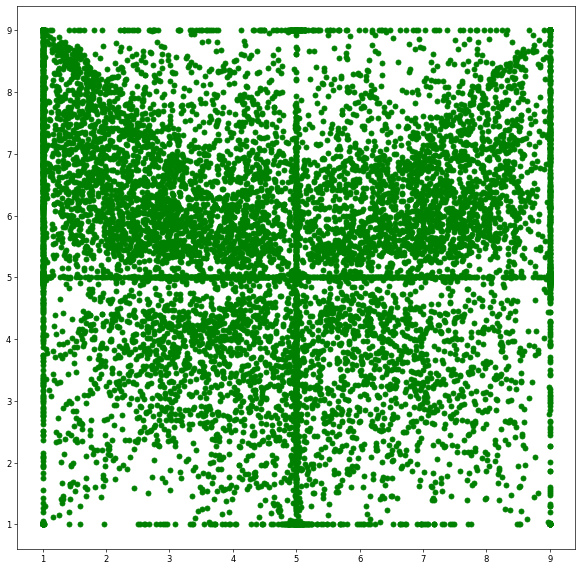

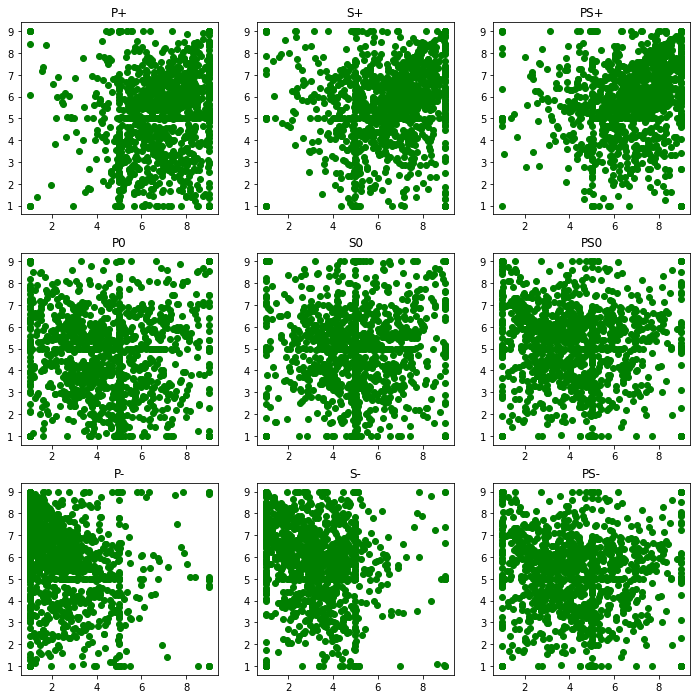

In [ ]:
valence = procedure['ANS_VALENCE']
arousal = procedure['ANS_AROUSAL']
plt.figure(figsize=(12, 12), dpi=60)
plt.scatter(valence, arousal, color = "green")
#P+, P0, P-, S+, S0, S-, PS+, PS0, PS-
figure, axs = plt.subplots(3,3, figsize=(12, 12))

pplus_cond = procedure[(procedure['COND'] == 'P+')]
pplus_valence = pplus_cond['ANS_VALENCE']
pplus_arousal = pplus_cond['ANS_AROUSAL']

pzero_cond = procedure[(procedure['COND'] == 'P0')]
pzero_valence = pzero_cond['ANS_VALENCE']
pzero_arousal = pzero_cond['ANS_AROUSAL']

pminus_cond = procedure[(procedure['COND'] == 'P-')]
pminus_valence = pminus_cond['ANS_VALENCE']
pminus_arousal = pminus_cond['ANS_AROUSAL']

pminus_cond = procedure[(procedure['COND'] == 'S+')]
splus_valence = pminus_cond['ANS_VALENCE']
splus_arousal = pminus_cond['ANS_AROUSAL']

szero_cond = procedure[(procedure['COND'] == 'S0')]
szero_valence = szero_cond['ANS_VALENCE']
szero_arousal = szero_cond['ANS_AROUSAL']

sminus_cond = procedure[(procedure['COND'] == 'S-')]
sminus_valence = sminus_cond['ANS_VALENCE']
sminus_arousal = sminus_cond['ANS_AROUSAL']

psplus_cond = procedure[(procedure['COND'] == 'PS+')]
psplus_valence = psplus_cond['ANS_VALENCE']
psplus_arousal = psplus_cond['ANS_AROUSAL']

pszero_cond = procedure[(procedure['COND'] == 'PS0')]
pszero_valence = pszero_cond['ANS_VALENCE']
pszero_arousal = pszero_cond['ANS_AROUSAL']

psminus_cond = procedure[(procedure['COND'] == 'PS-')]
psminus_valence = psminus_cond['ANS_VALENCE']
psminus_arousal = psminus_cond['ANS_AROUSAL']


axs[0, 0].scatter(pplus_valence, pplus_arousal, color = "green")
axs[0, 0].set_title("P+")
axs[1, 0].scatter(pzero_valence, pzero_arousal, color = "green")
axs[1, 0].set_title("P0")
axs[2, 0].scatter(pminus_valence, pminus_arousal, color = "green")
axs[2, 0].set_title("P-")
axs[0, 1].scatter(splus_valence, splus_arousal, color = "green")
axs[0, 1].set_title("S+")
axs[1, 1].scatter(szero_valence, szero_arousal, color = "green")
axs[1, 1].set_title("S0")
axs[2, 1].scatter(sminus_valence, sminus_arousal, color = "green")
axs[2, 1].set_title("S-")
axs[0, 2].scatter(psplus_valence, psplus_arousal, color = "green")
axs[0, 2].set_title("PS+")
axs[1, 2].scatter(pszero_valence, pszero_arousal, color = "green")
axs[1, 2].set_title("PS0")
axs[2, 2].scatter(pszero_valence, pszero_arousal, color = "green")
axs[2, 2].set_title("PS-")

### Student's t-test and Wilcoxon signed-rank test

As you probably noticed (on the plots), it seems that the **valence** scores are much lower for `-` condition (`P-`, `S-`, `PS-`) than for neutral one (`P0`, `S0`, `PS0`), and much higher for `+` condition (`P+`, `S+`, `PS+`) than for neutral one.

We will examine this in a moment, but first we need to clarify the key concepts...

**Task 3**: Taking the above situation as an example (verifying if the valence is lower in the `-` condition than in the neutral group), describe (in a few words) what are **Null hypothesis** and **Alternative hypothesis**

`_FILL_IN_YOUR_ANSWERS_HERE`

In [ ]:
#Null Hipothesis: Valence isn't lower in the - condition than in the neutral group.
#Alternative Hipothesis: Valence is lower in the - condition than in the neutral group.

**Task 4:** Verify whether the differences mentioned do indeed exist. To do so, perform two t-tests (`-` vs `0` and `+` vs `0`).

Note: use the test for related samples (as the results for both conditions are from the same subjects group) not the independent ones! (e.g., [`scipy.stats.ttest_rel()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)) 

In [ ]:
# _FILL_IN_YOUR_CODE_HERE 
plus = (procedure['COND'] == 'P+') | (procedure['COND'] == 'S+') | (procedure['COND'] == 'PS+')
minus = (procedure['COND'] == 'P-') | (procedure['COND'] == 'S-') | (procedure['COND'] == 'PS-')
zero = (procedure['COND'] == 'P0') | (procedure['COND'] == 'S0') | (procedure['COND'] == 'PS0')

plus = plus.astype('float32')
minus = minus.astype('float32')
zero = zero.astype('float32')

pvz = stats.ttest_rel(plus, zero)
mvz = stats.ttest_rel(minus, zero)
print(pvz)
print(mvz) 

Ttest_relResult(statistic=-0.04508348000805973, pvalue=0.964040769767488)
Ttest_relResult(statistic=-0.11275167764654678, pvalue=0.9102274313344407)


**Task 5**: But... Did you remember to check the assumptions of the t-test? You can use the Shapiro-Wilks Test to check the normality of the sample ([`scipy.stats.shapiro()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)).

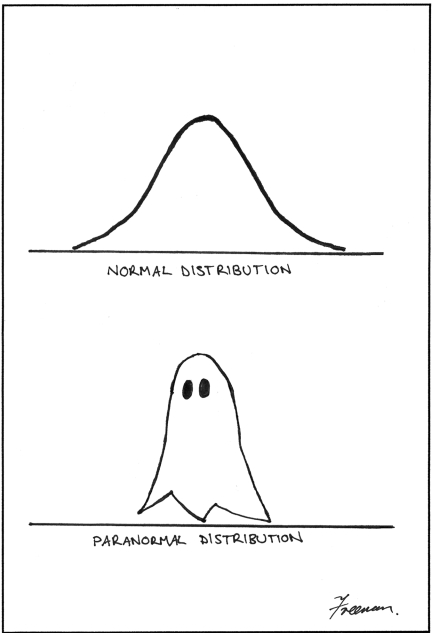

*([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2465539/))*

*Note: We test the normality of the distribution here to emphasise that it is important to **check the assumptions** of each test we perform.*

*In real life situations, checking the normality of the distribution before the t-test is not really necessary. Check [the slides](https://www.researchgate.net/publication/299497976_Silly_or_Pointless_Things_People_Do_When_Analyzing_Data_1_Testing_for_Normality_as_a_Precursor_to_a_t-test) for more details.*

In [ ]:
# _FILL_IN_YOUR_CODE_HERE 


Oh... The p-value is smaller than 0.05, so the data was **not** drawn from a normal distribution, and we cannot use the t-test...

But we can use the **non-parametric** test instead: the Wilcoxon signed-rank test ([`scipy.stats.wilcoxon()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)).  
*(Do you know what the **non-parametric** means?)*

Note: when the samples are **independent**, the proper non-parametric test is the Mann-Whitney U rank test ([`scipy.stats.mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)).

**Task 6**: perform the Wilcoxon test to evaluate the differences in valence scores - now the results will be realible, so you can finally state whether there are differences or not!

In [ ]:
# _FILL_IN_YOUR_CODE_HERE 
# AND STATE WHETHER THERE ARE SIGNIFICANT DIFFERENCES OR NOT :)


### ANOVA

Hooray! There are significant differences between `+`/`-` and `0` conditions!  

But analyses of our data are not limited to such simple differences. In our dataset we also has the personality profile (represented as five variables in `metadata`). How do they impact our dependent variables (`ANS-VALENCE` and `ANS-AROUSAL`)?

First, we need to combine these variables into our `procedure` dataset:

In [ ]:
# to speed-up the process, you can remove the rows without the ANS values...
procedure = procedure[procedure['ANS_VALENCE'].notnull()]
# ... and training-related rows
procedure = procedure[procedure['COND'] != 'train']

In [ ]:
procedure = pd.merge(procedure, metadata, how="left", on="ID")

In [ ]:
procedure.head()

**Task 7**: Perform the ANOVA (more precisely 5-way ANOVA as we have five independent variables) to check how `ANS_VALENCE` (and `ANS_AROUSAL`) is influenced by the personality profile.

Note 1: Remember that we have repeated / dependent measures (i.e., one subject was in all groups), so we have to include random effects for each subject. We can use [linear mixed effects models](https://www.statsmodels.org/stable/mixed_linear.html) and their implementation in `statsmodels` (as `scipy` does not support it).

Note 2: As a result of this step you should get a table with some p-values related to independent variables

Note 3: The formula takes the form: `DEP ~ IND_1 + IND_2 + IND_1*IND_2`, where `DEP` is dependent variable, `IND_X` is independent variable, `+` means another factor and `*` indicates interaction between factors.

Note 4: You need two models (one for valence and one for arousal) or you need to perform MANOVA (M stands for multiple dependent variables)

Note 5: The p-value is in the `P>|z|` column.

In [ ]:
# _FILL_IN_YOUR_CODE_HERE


A significant result in ANOVA only tells us that the null hypothesis of equality of all levels of a given variable / given interaction of variables has been rejected. So there is some difference, but we don't know between which levels. To examine this we need to do additional post-hoc tests.

**Task 8:** Do the post-hoc tests for significant results in ANOVA(s).

Tip: You can use [`pairwise_tukeyhsd()`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html) from `statmodels`.

In [ ]:
# _FILL_IN_YOUR_CODE_HERE



### This place is for you!

If class isn't over and you still have some time, now is a good time to do some analysis of your own. Do you have any ideas on what you can investigate?